In [2]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

## Prepare dataset

In [3]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

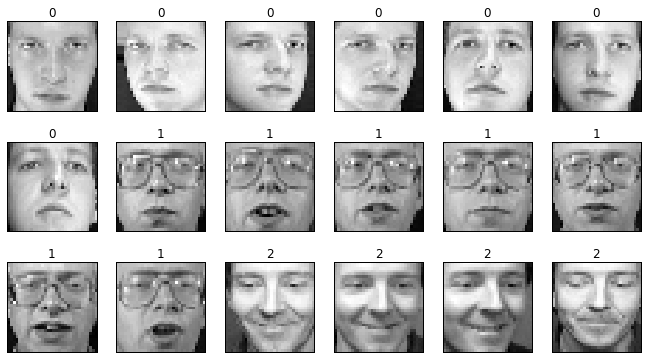

In [5]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.
knn = KNeighborsClassifier()
knn.fit(X_train, y_train.ravel())
test_score = knn.score(X_test, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.783333333333


Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

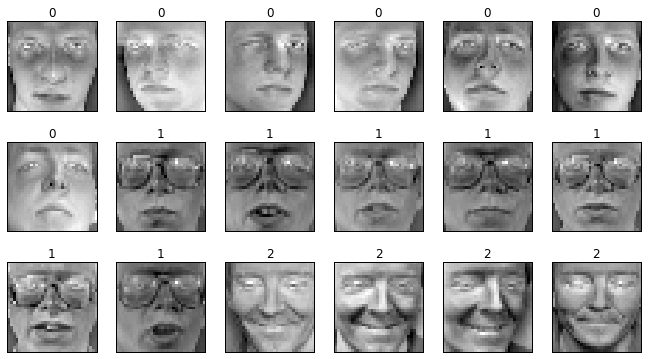

In [9]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
X_train_normalized = X_train.copy().astype(np.float64)
 
X_train_std = np.std(X_train, 0)
X_train_mean = np.mean(X_train, 0)

X_train_normalized = (X_train - X_train_mean) / X_train_std 
X_test_normalized = (X_test - X_train_mean) / X_train_std 
    
plot_gallery(X_train_normalized, titles, image_h, image_w)

Now we are going to apply **PCA** to obtain a dictionary of codewords. 
**`RamdomizedPCA`** class is what we need.

In [10]:
from sklearn.decomposition import RandomizedPCA

n_components = 64

# Populate 'pca' with a trained instance of RamdomizedPCA.

pca = RandomizedPCA(n_components = n_components)
pca.fit(X_train_normalized)

RandomizedPCA(copy=True, iterated_power=3, n_components=64, random_state=None,
       whiten=False)

We plot a bunch of principal components.

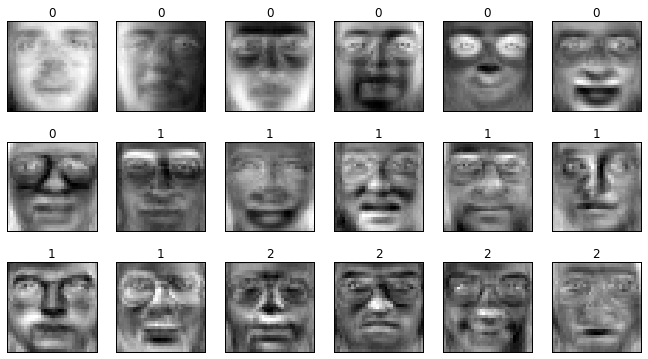

In [11]:
# Visualize principal components.
plot_gallery(pca.components_, titles, image_h, image_w)

This time we don't have any restriction on number of non-zero coefficients in the vector decomposition, so the codes are not sparse anymore:

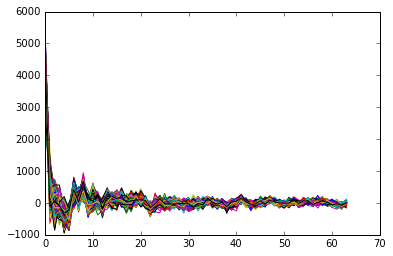

In [14]:
# Transform training data and plot decomposition coefficients.
pca_training_transformed = pca.transform(X_train)
for coefficient in pca_training_transformed:
    plt.plot(coefficient)


Train an SVM and apply it to the encoded test data.

In [15]:
# Populate 'test_score' with test accuracy of an SVM classifier.
from sklearn.svm import SVC

svm = SVC(kernel='linear')
pca_training_normalized_transformed = pca.transform(X_train_normalized)
pca_test_normalized_transformed = pca.transform(X_test_normalized)

svm.fit(pca_training_normalized_transformed, y_train.ravel())
test_score = svm.score(pca_test_normalized_transformed, y_test)

print('Test score: {}'.format(test_score))

Test score: 0.95


How many components are sufficient to reach the same accuracy level?

Components: 1 | Accuracy:0.133333333333
Components: 2 | Accuracy:0.158333333333
Components: 4 | Accuracy:0.658333333333
Components: 8 | Accuracy:0.775
Components: 16 | Accuracy:0.9
Components: 32 | Accuracy:0.933333333333
Components: 64 | Accuracy:0.95
Max accuracy: 0.95


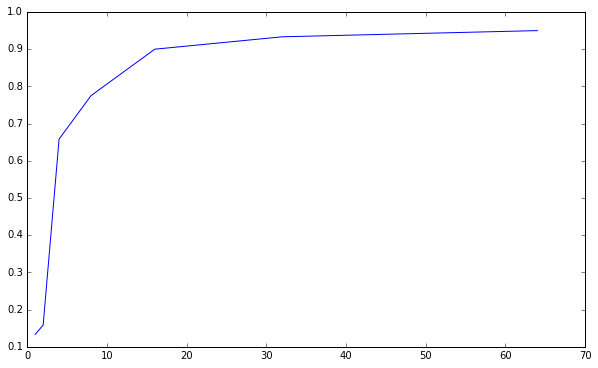

In [29]:
n_components = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

# Try different numbers of components and populate 'accuracy' list.
for component in n_components:
    pca = RandomizedPCA(n_components = component)
    pca.fit(X_train_normalized)
    svm = SVC(kernel='linear')
    pca_training_normalized_transformed = pca.transform(X_train_normalized)
    pca_test_normalized_transformed = pca.transform(X_test_normalized)

    svm.fit(pca_training_normalized_transformed, y_train.ravel())
    score = svm.score(pca_test_normalized_transformed, y_test)
    accuracy.append(score)
    print 'Components: '+str(component)+' | Accuracy:'+str(score)

    
plt.figure(figsize=(10, 6))
#plt.plot(n_nonzero, accuracy)
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))